TIPE MODELE 2

In [14]:
import pandas as pd
import numpy as np
import os,typing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers,models
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
import random


In [15]:
def recup_data_avenue(file, features):
    # on  lit le dataset brut
    data = pd.read_csv(file, sep=';', low_memory=False)

    # on récupère les colonnes ("Débit horaire" ; "Taux d'occupation")
    columns_used = ["Date et heure de comptage", features]

    data = data[data["Libelle"] == "La_Fayette"]


    # on retire toutes les colonnes dont on ne va pas se servir
    to_drop = data.columns.difference(columns_used)
    data.drop(to_drop, axis=1, inplace=True)

    # on trie par date et heure de comptage
    data.sort_values([columns_used[0]], inplace=True)
    data.reset_index(drop=True, inplace=True)

    #on retire les lignes inutiles et on renvoie le tableau sans valeurs manquantes
    data = data[data[columns_used[1]].notna()]


    #on regroupe les lignes par même jour même heure et on fait la moyenne
    test = data.groupby([columns_used[0]]).mean()


    data.reset_index(drop=True, inplace=True)

    #on transforme les données panda en données numpy
    matrice = data.to_numpy()

    n = len(test)

    matrice_zeros = np.zeros((n//24 +1,24))

    for i in range(0,n//24):
        date = matrice[i][0]
        for j in range(24):
            matrice_zeros[i][j] = matrice[i*24 + j][1]

    matrice_zeros = np.delete(matrice_zeros,(n//24), axis=0)


    return matrice_zeros




In [16]:

dataset = r"dataset_paris.csv"

scale = 1.0 # de base 0.6
train_prop = .6 #de base 0.8
sequence_len = 16 #de base 16
batch_size = 32 #de base 32
epochs = 100 #de base 100
features = ["Débit horaire"]
features_len = 24 #de base 24


In [19]:

#data = modif(dataset)
data = recup_data_avenue(dataset, features=features[0])

#on utilise les proportions choisies
data = data[:int(scale*len(data))]
train_len = int(train_prop*len(data))


#on crée les dataset d'entrainements et de test
dataset_train = data[:train_len]
dataset_test = data[train_len:]

#on normalise
mean = dataset_test.mean()
std = dataset_train.std()

dataset_train = (dataset_train - mean)/std
dataset_test = (dataset_test - mean) / std

In [20]:

train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len, batch_size=batch_size)
test_generator = TimeseriesGenerator(dataset_test, dataset_test, length=sequence_len, batch_size=batch_size)


#Creation du modele

model = Sequential()
model.add(keras.layers.InputLayer(input_shape= (sequence_len,24)))
model.add(keras.layers.LSTM(100, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(24))
model.summary()


model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])


#entrainenement du model
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=2,
                    validation_data= test_generator,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])


historique = pd.DataFrame(history.history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               50000     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                2424      
                                                                 
Total params: 52,424
Trainable params: 52,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 - 1s - loss: 1.0198 - mae: 0.8804 - val_loss: 0.9491 - val_mae: 0.8545 - 1s/epoch - 346ms/step
Epoch 2/100
3/3 - 0s - loss: 0.9704 - mae: 0.8617 - val_loss: 0.9291 - val_mae: 0.8465 - 60ms/epoch - 20ms/step
Epoch 3/100
3/3 - 0s - loss: 0.9453 - mae: 0.8506 - val_loss: 0.9132 - val_mae: 0.8387 - 56

In [21]:

def predict():
    for p in range(3):
        s = random.randint(0,len(dataset_train)-sequence_len)

        sequence = dataset_test[s:s + sequence_len]
        sequence_true = dataset_test[s: s + sequence_len + 1 ]

        pred = model.predict(np.array([sequence]))


        def denormalize(seq):
            nseq = seq.copy()
            for i,s in enumerate(nseq):
                s = s*std + mean
                nseq[i] = s
            return nseq

        prediction = denormalize(pred)
        real = denormalize(sequence_true[-1])
        real_1 = denormalize(sequence_true[-2])
        real_2 = denormalize(sequence_true[-3])

        #on récupère les quelques jours avant pour comparer
        sequence_real = [real, real_1]

        hours = np.arange(1,25)

        print(prediction, real)

        plt.plot(hours,prediction[0], "o-", label = "Prédictions")
        for k, verite in enumerate(sequence_real):
            plt.plot(hours, verite, "o-", label = f"Valeurs réelles : J-{k}")

        plt.legend()
        plt.title(f"{features[0]}, Paramètres : epochs = {epochs} , sequence_len = {sequence_len}, batch_size = {batch_size}")
        plt.show()

1/1 [==============================] - 0s 117ms/step
[[597.3805  662.4984  551.51587 626.4328  589.752   610.8958  577.21094
  567.99805 481.1609  586.89636 550.685   626.1082  485.12234 576.85693
  559.86584 507.9537  601.0457  493.32346 548.31885 590.527   605.34753
  500.3051  539.1132  547.1743 ]] [481. 508. 481. 392.  89. 320. 320. 320. 331.  66. 331. 333. 333. 378.
 313. 325.  79. 313. 313. 281. 306. 221. 221. 186.]


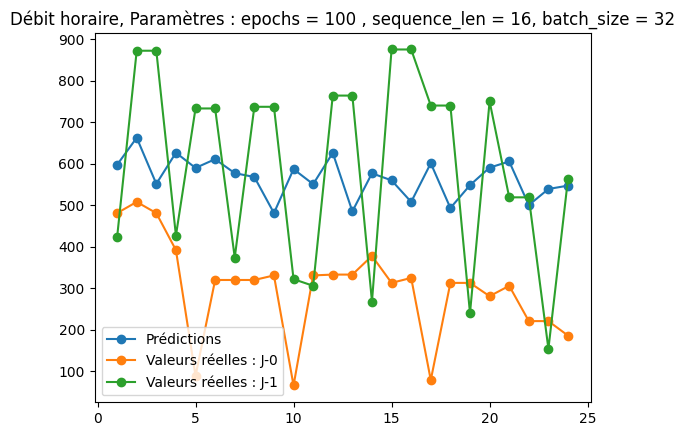

1/1 [==============================] - 0s 20ms/step
[[623.9239  603.677   626.67334 569.94904 619.76544 631.4883  676.62976
  638.0973  640.2293  636.7901  687.1116  637.4357  584.15674 682.72626
  680.9773  656.6044  688.38196 665.90454 705.353   690.81445 678.7876
  639.2984  661.7003  617.7902 ]] [834. 751. 916. 342. 751. 834. 342. 793. 793. 324. 767. 793. 324. 767.
 793. 940. 797. 307. 307. 797. 797. 891. 797. 812.]


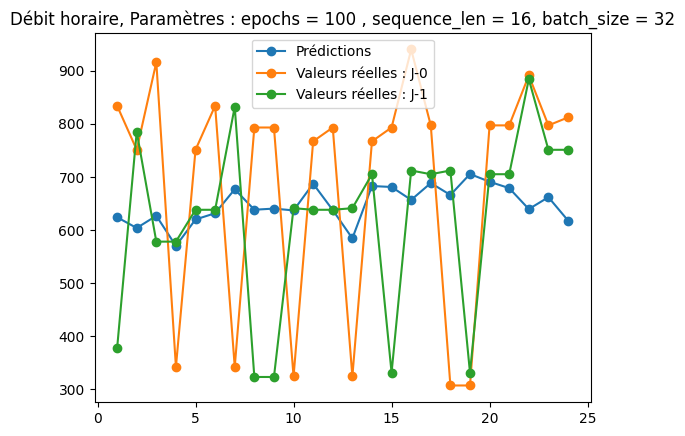

1/1 [==============================] - 0s 17ms/step
[[585.5371  637.7632  647.0965  611.68024 668.68    609.81256 745.2603
  612.3097  700.6351  685.3873  676.8311  716.28564 632.28595 753.57874
  755.9944  752.3704  799.76245 683.8292  708.0652  765.59424 762.00183
  716.81085 766.9889  703.3728 ]] [505. 517. 531. 531. 531. 517. 531. 723. 415. 415. 686. 414. 686. 691.
 691. 414. 686. 750. 686. 773. 742. 773. 395. 773.]


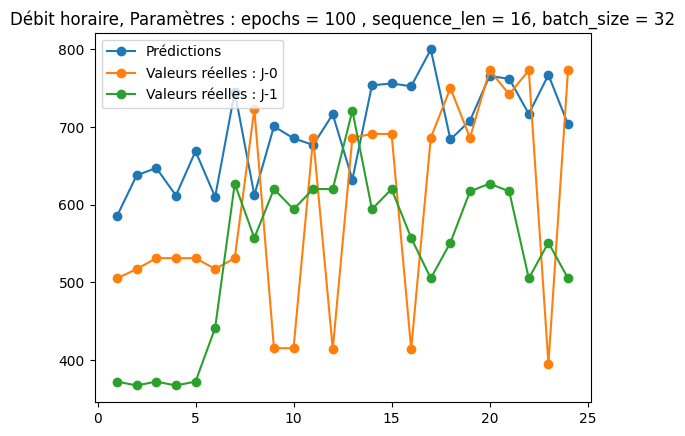

In [23]:
predict()